# Tully problem 2 

In [1]:
import sys
import cmath
import math
import os

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *

from libra_py import units
from libra_py import models_Tully
from libra_py import tsh
from libra_py import tsh_stat
from libra_py import tsh_algo1
from libra_py import data_conv

import matplotlib.pyplot as plt   # plots
import numpy as np
#from matplotlib.mlab import griddata

%matplotlib inline 

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::complex<double>, std::allocator<std::complex<double> > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, s

## 1. Model Hamiltonian 

In [2]:
xmin = -10.0
xmax = 10.0
dx = 0.01

X = []
nsteps = int((xmax - xmin) / dx) + 1

for i in range(nsteps):
    X.append(xmin + i * dx)

In [3]:
H00, H11, H01 = [], [], []
dH00, dH11, dH01 = [], [], []
for i in range(nsteps):
    q = MATRIX(1,1); q.set(0, 0, X[i])
    obj = models_Tully.Tully2(q, {"A":0.10, "B":0.28, "C":0.015, "D":0.060, "E":0.050 })
    
    H00.append(obj.ham_dia.get(0,0).real)
    H11.append(obj.ham_dia.get(1,1).real)
    H01.append(obj.ham_dia.get(0,1).real)    
    
    dH00.append(obj.d1ham_dia[0].get(0,0).real)
    dH11.append(obj.d1ham_dia[0].get(1,1).real)
    dH01.append(obj.d1ham_dia[0].get(0,1).real) 

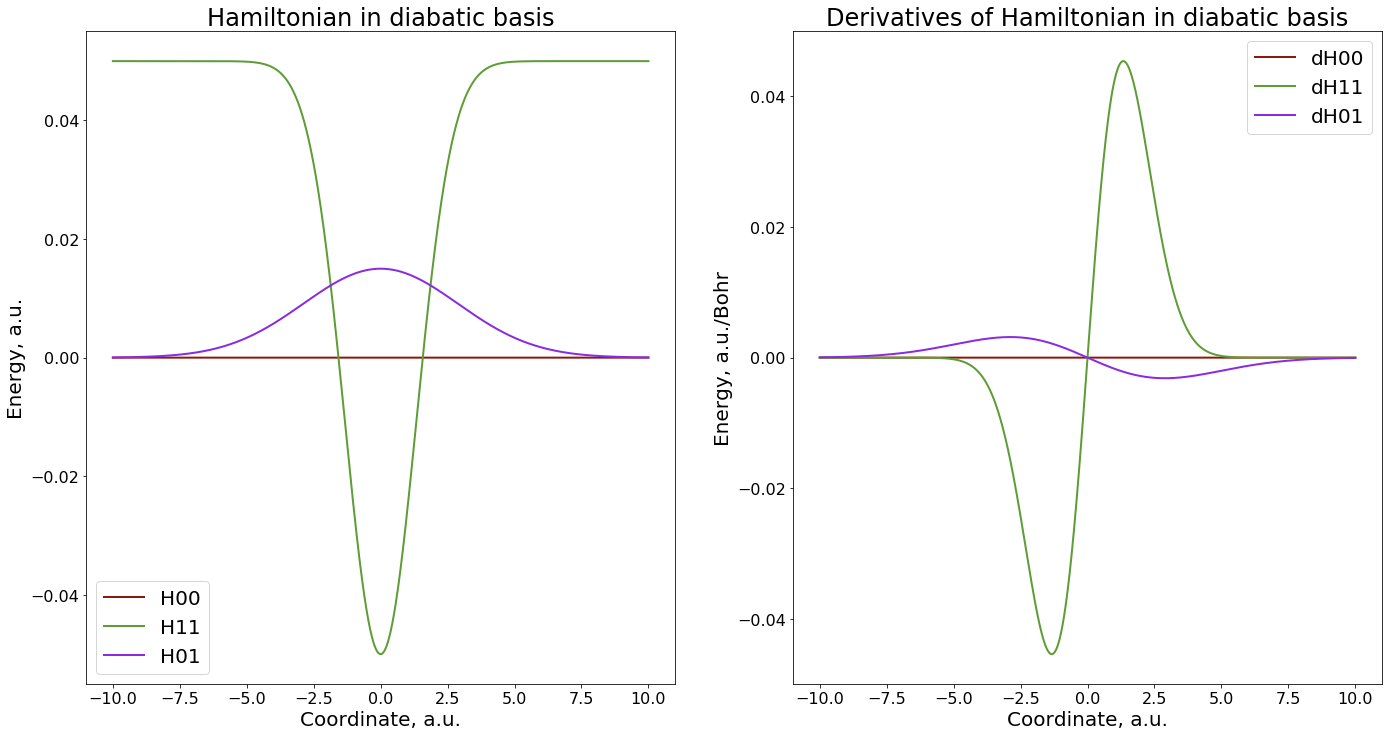

In [4]:
plt.figure(1, figsize=(24, 12)) # dpi=300, frameon=False)
plt.subplot(1,2,1)
plt.title('Hamiltonian in diabatic basis')
plt.xlabel('Coordinate, a.u.')
plt.ylabel('Energy, a.u.')
plt.plot(X, H00, label='H00', linewidth=2, color = colors["11"]) 
plt.plot(X, H11, label='H11', linewidth=2, color = colors["21"]) 
plt.plot(X, H01, label='H01', linewidth=2, color = colors["31"]) 
plt.legend()


plt.subplot(1,2,2)
plt.title('Derivatives of Hamiltonian in diabatic basis')
plt.xlabel('Coordinate, a.u.')
plt.ylabel('Energy, a.u./Bohr')
plt.plot(X, dH00, label='dH00', linewidth=2, color = colors["11"]) 
plt.plot(X, dH11, label='dH11', linewidth=2, color = colors["21"]) 
plt.plot(X, dH01, label='dH01', linewidth=2, color = colors["31"]) 
plt.legend()


plt.show()
plt.close()

## 2. A single scattering run

First, define the model to compute the Hamiltonian and derivatives

In [5]:
def compute_model(q, params, full_id):

    model = params["model"]
    res = None

    Id = Cpp2Py(full_id)
    indx = Id[-1]

    if model==1:
        res = models_Tully.Tully1(q.col(indx), params)
    elif model==2:
        res = models_Tully.Tully2(q.col(indx), params)
    elif model==3:
        res = models_Tully.Tully3(q.col(indx), params)

    #res.rep = params["rep"]    

    return res


Setup dynamical variables, model parameters, simulations parameters and run the calculations

In [6]:
# Random numbers generator object
rnd = Random()


# Dimensionality and dynamical variables
ndia, nadi, nnucl, ntraj = 2, 2, 1, 25

mean_q = MATRIX(nnucl,1);   mean_q.set(0,0, -12.0)
sigma_q = MATRIX(nnucl,1);  sigma_q.set(0,0, 0.0)
mean_p = MATRIX(nnucl,1);   mean_p.set(0,0, 20.0)
sigma_p = MATRIX(nnucl,1);  sigma_p.set(0,0, 0.0)

q = MATRIX(nnucl,ntraj);  tsh.sample(q, mean_q, sigma_q, rnd)
p = MATRIX(nnucl,ntraj);  tsh.sample(p, mean_p, sigma_p, rnd)
iM = MATRIX(nnucl,1);     iM.set(0,0, 1.0/2000.0)

istate = 0
Cdia, Cadi = CMATRIX(ndia, ntraj), CMATRIX(nadi, ntraj)
states = intList() 

for traj in range(ntraj):
    Cadi.set(istate, traj, 1.0+0.0j);  
    states.append(istate) 


# Model parameters 
model_params = { "model":2, "A":0.10, "B":0.28, "C":0.015, "D":0.060, "E":0.050 }

# Dynamics (Simulation) parameters
dyn_params = { "rep":1, "rep_sh":1, "tsh_method":0, "use_boltz_factor":0,
               "nsteps":5000,
               "Temperature":300.0, "do_reverse":1, "vel_rescale_opt":1, "dt":1.0 }

res = tsh_algo1.run_tsh(q, p, iM, Cdia, Cadi, states, model_params, dyn_params, compute_model, rnd)

Extract the results of the calculation and plot them

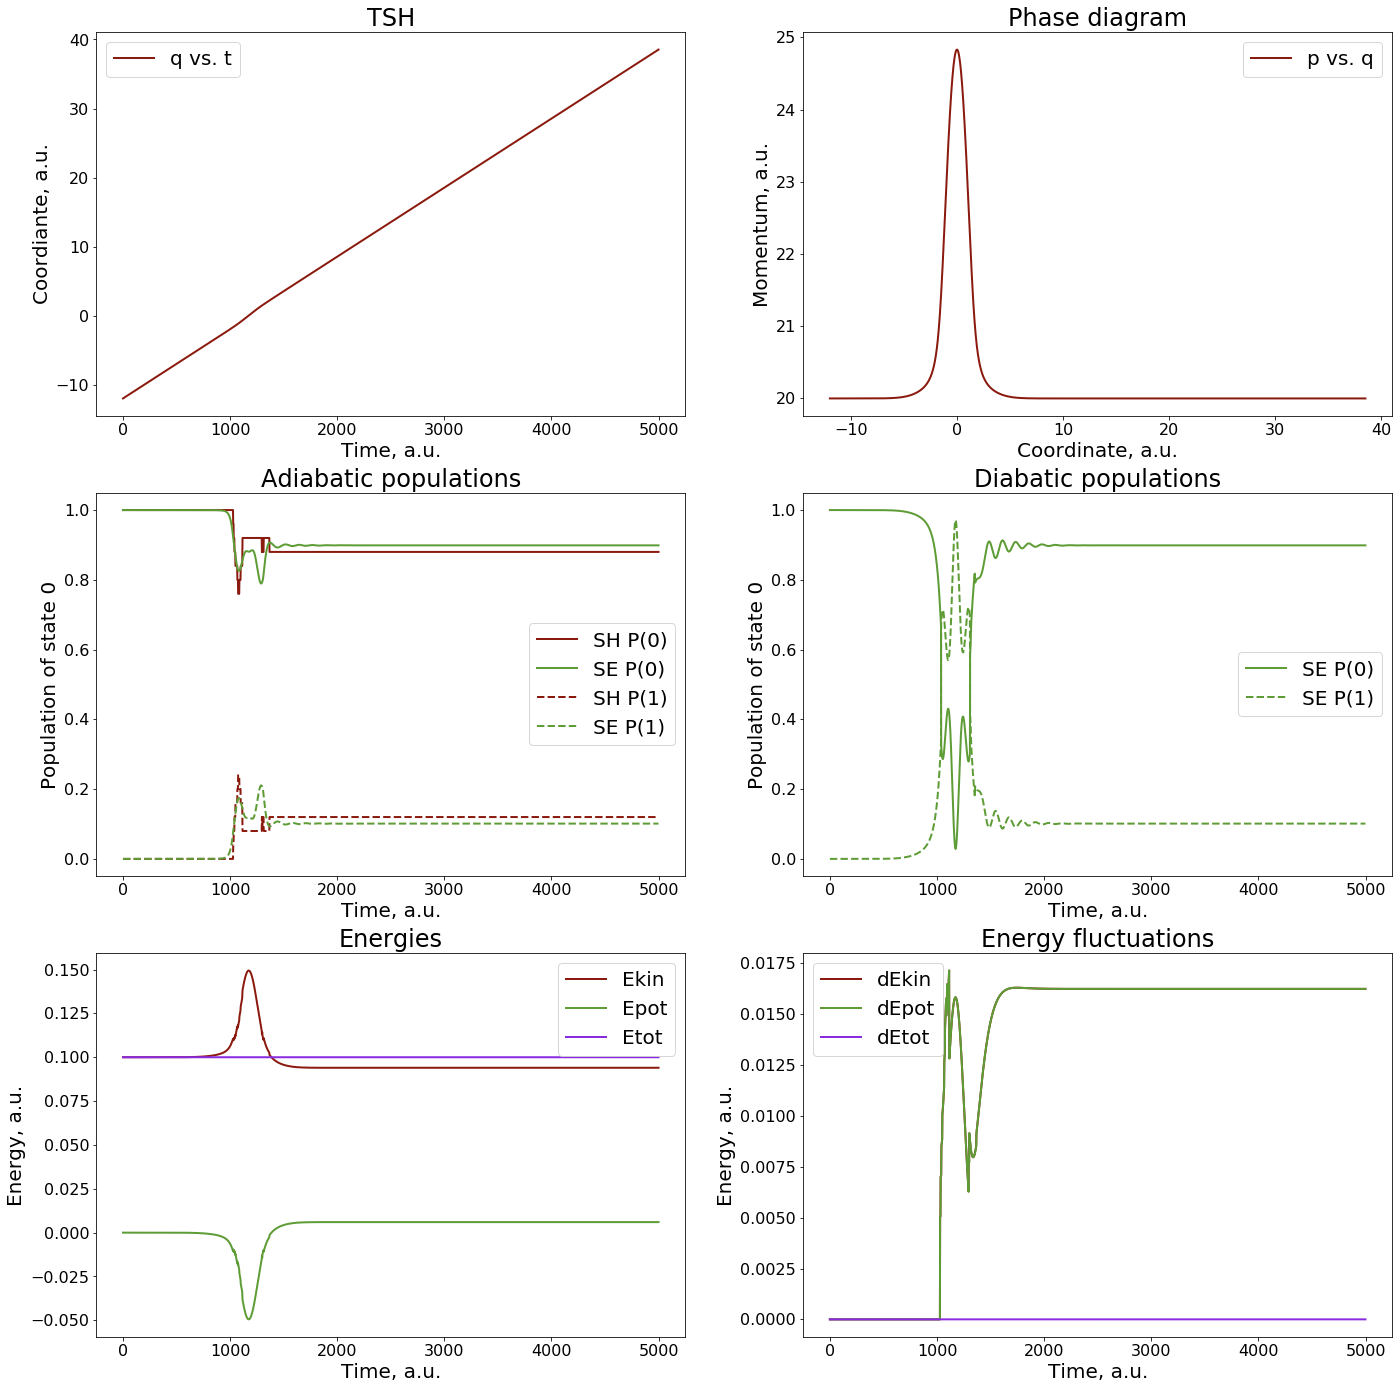

In [7]:
# Format: 
#   0      1      2       3        4        5           6          7        8            9       10        11            12        13       14 
#obs_T, obs_q, obs_p, obs_Ekin, obs_Epot, obs_Etot, obs_dEkin, obs_dEpot, obs_dEtot, obs_Cadi, obs_Cdia, obs_dm_adi, obs_dm_dia, obs_pop  obs_states

obs_T = res[0]
obs_q = data_conv.unpack1(res[1], 0, 0, 2)
obs_p = data_conv.unpack1(res[2], 0, 0, 2)
obs_Ekin = res[3]
obs_Epot = res[4]
obs_Etot = res[5]
obs_dEkin = res[6]
obs_dEpot = res[7]
obs_dEtot = res[8]
obs_dm_adi00 = data_conv.unpack1(res[11], 0, 0, 0)
obs_dm_adi11 = data_conv.unpack1(res[11], 1, 1, 0)
obs_dm_dia00 = data_conv.unpack1(res[12], 0, 0, 0)
obs_dm_dia11 = data_conv.unpack1(res[12], 1, 1, 0)
obs_pop00 = data_conv.unpack1(res[13], 0, 0, 2)
obs_pop11 = data_conv.unpack1(res[13], 1, 0, 2)



plt.figure(1, figsize=(24, 24)) # dpi=300, frameon=False)
plt.subplot(3,2,1)
plt.title('TSH')
plt.xlabel('Time, a.u.')
plt.ylabel('Coordiante, a.u.')
plt.plot(obs_T, obs_q, label='q vs. t', linewidth=2, color = colors["11"]) 
plt.legend()

plt.subplot(3,2,2)
plt.title('Phase diagram')
plt.xlabel('Coordinate, a.u.')
plt.ylabel('Momentum, a.u.')
plt.plot(obs_q, obs_p, label='p vs. q', linewidth=2, color = colors["11"]) 
plt.legend()


plt.subplot(3,2,3)
plt.title('Adiabatic populations')
plt.xlabel('Time, a.u.')
plt.ylabel('Population of state 0')
plt.plot(obs_T, obs_pop00, label='SH P(0)', linewidth=2, color = colors["11"]) 
plt.plot(obs_T, obs_dm_adi00, label='SE P(0)', linewidth=2, color = colors["21"]) 
plt.plot(obs_T, obs_pop11, "--", label='SH P(1)', linewidth=2, color = colors["11"]) 
plt.plot(obs_T, obs_dm_adi11, "--", label='SE P(1)', linewidth=2, color = colors["21"]) 
plt.legend()

plt.subplot(3,2,4)
plt.title('Diabatic populations')
plt.xlabel('Time, a.u.')
plt.ylabel('Population of state 0')
plt.plot(obs_T, obs_dm_dia00, label='SE P(0)', linewidth=2, color = colors["21"]) 
plt.plot(obs_T, obs_dm_dia11, "--", label='SE P(1)', linewidth=2, color = colors["21"]) 
plt.legend()

plt.subplot(3,2,5)
plt.title('Energies')
plt.xlabel('Time, a.u.')
plt.ylabel('Energy, a.u.')
plt.plot(obs_T, obs_Ekin, label='Ekin', linewidth=2, color = colors["11"]) 
plt.plot(obs_T, obs_Epot, label='Epot', linewidth=2, color = colors["21"]) 
plt.plot(obs_T, obs_Etot, label='Etot', linewidth=2, color = colors["31"]) 
plt.legend()

plt.subplot(3,2,6)
plt.title('Energy fluctuations')
plt.xlabel('Time, a.u.')
plt.ylabel('Energy, a.u.')
plt.plot(obs_T, obs_dEkin, label='dEkin', linewidth=2, color = colors["11"]) 
plt.plot(obs_T, obs_dEpot, label='dEpot', linewidth=2, color = colors["21"]) 
plt.plot(obs_T, obs_dEtot, label='dEtot', linewidth=2, color = colors["31"]) 
plt.legend()


plt.show()
plt.close()

## 3. Scattering calculations with different initial momenta

In [8]:
def run_scan(p0, tsh_version):
    # Dimensionality and dynamical variables
    ndia, nadi, nnucl, ntraj = 2, 2, 1, 50

    mean_q = MATRIX(nnucl,1);   mean_q.set(0,0, -12.0)
    sigma_q = MATRIX(nnucl,1);  sigma_q.set(0,0, 0.0)
    mean_p = MATRIX(nnucl,1);   mean_p.set(0,0, p0)
    sigma_p = MATRIX(nnucl,1);  sigma_p.set(0,0, 0.0)

    q = MATRIX(nnucl,ntraj);  tsh.sample(q, mean_q, sigma_q, rnd)
    p = MATRIX(nnucl,ntraj);  tsh.sample(p, mean_p, sigma_p, rnd)
    iM = MATRIX(nnucl,1);     iM.set(0,0, 1.0/2000.0)

    istate = 0
    Cdia, Cadi = CMATRIX(ndia, ntraj), CMATRIX(nadi, ntraj)
    states = intList() 

    for traj in range(ntraj):
        Cadi.set(istate, traj, 1.0+0.0j);  
        states.append(istate) 

    # Model parameters 
    model_params = { "model":2, "A":0.10, "B":0.28, "C":0.015, "D":0.060, "E":0.050  }

    # Dynamics (Simulation) parameters
    dyn_params = { "rep":1, "rep_sh":1, "tsh_method":0, "use_boltz_factor":0,
                   "nsteps":10000, "tsh_version":tsh_version,
                   "Temperature":300.0, "do_reverse":1, "vel_rescale_opt":1, "dt":1.0 }

    res = tsh_algo1.run_tsh(q, p, iM, Cdia, Cadi, states, model_params, dyn_params, compute_model, rnd)
    
    return res

In [9]:
P0 = [5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0]
scan_res = []
for p0 in P0:
    res = run_scan(p0, 1)
    scan_res.append(res)        

In [10]:
# Format: 
#   0      1      2       3        4        5           6          7        8            9       10        11            12        13        14 
#obs_T, obs_q, obs_p, obs_Ekin, obs_Epot, obs_Etot, obs_dEkin, obs_dEpot, obs_dEtot, obs_Cadi, obs_Cdia, obs_dm_adi, obs_dm_dia, obs_pop  obs_states

# scan_res[icond][ivar][istep][i]       for lists
# scan_res[icond][ivar][istep].get(i,j) for matrices

nsteps = len(scan_res[0][0])
ntraj = len(scan_res[0][14][0])

icond = 0 
last_q = scan_res[icond][1][nsteps-1]
last_states = scan_res[icond][14][nsteps-1]

#for n in xrange(ntraj):
#    print n, last_q.get(0, n), last_states[n]


In [11]:
ncond = len(P0)
P_re, P_tr = [], []

for icond in range(ncond):
    
    last_q = scan_res[icond][1][nsteps-1]
    last_states = scan_res[icond][14][nsteps-1]

    pop_refl, pop_transm = tsh_algo1.probabilities_1D_scattering(last_q, last_states, 2, {"act_dof":0, "left_boundary":-12.0, "right_boundary":12.0} )                                     
    P_re.append(pop_refl)
    P_tr.append(pop_transm)

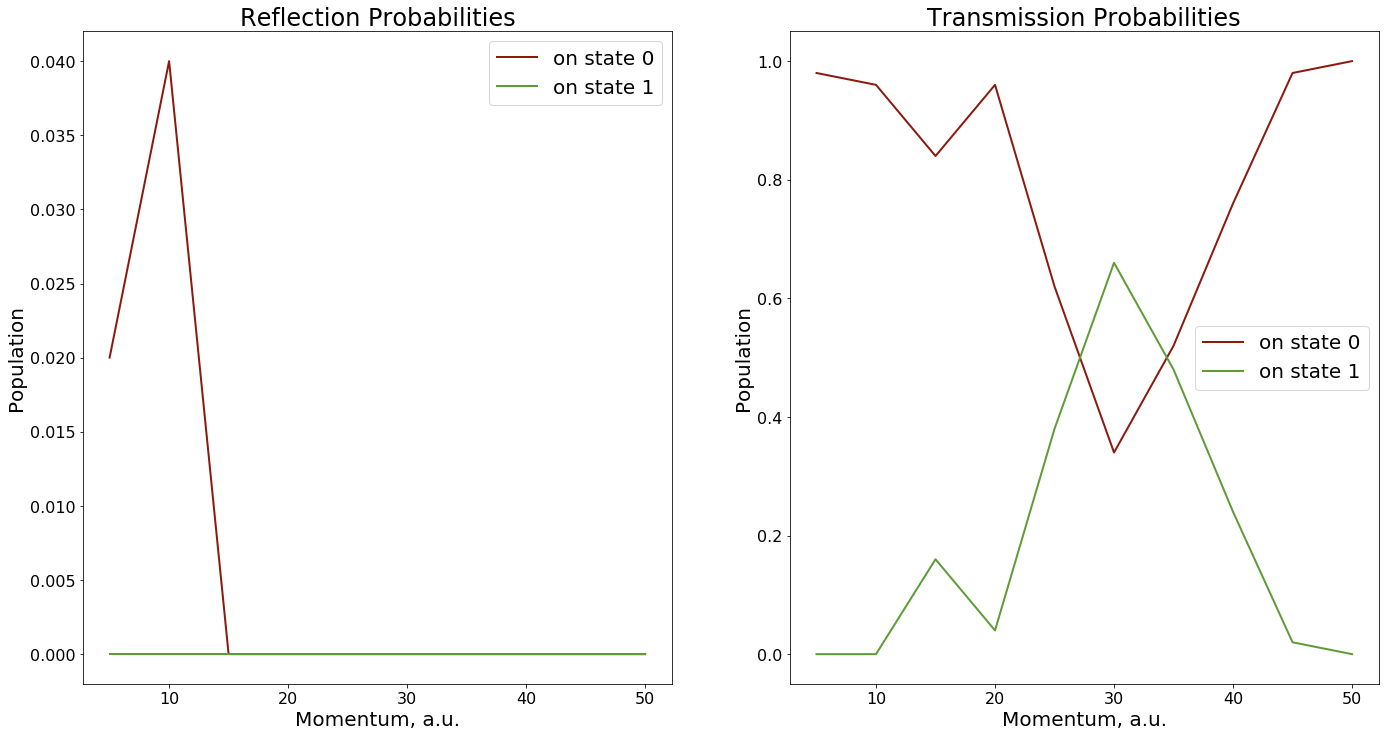

In [12]:
p_re0 = data_conv.unpack1(P_re, 0, 0, 2)
p_re1 = data_conv.unpack1(P_re, 1, 0, 2)
p_tr0 = data_conv.unpack1(P_tr, 0, 0, 2)
p_tr1 = data_conv.unpack1(P_tr, 1, 0, 2)

plt.figure(1, figsize=(24, 12)) # dpi=300, frameon=False)
plt.subplot(1,2,1)
plt.title('Reflection Probabilities')
plt.xlabel('Momentum, a.u.')
plt.ylabel('Population')
plt.plot(P0, p_re0, label='on state 0', linewidth=2, color = colors["11"]) 
plt.plot(P0, p_re1, label='on state 1', linewidth=2, color = colors["21"]) 
plt.legend()

plt.subplot(1,2,2)
plt.title('Transmission Probabilities')
plt.xlabel('Momentum, a.u.')
plt.ylabel('Population')
plt.plot(P0, p_tr0, label='on state 0', linewidth=2, color = colors["11"]) 
plt.plot(P0, p_tr1, label='on state 1', linewidth=2, color = colors["21"]) 
plt.legend()


plt.show()
plt.close()

In [14]:
lnE = []

for p0 in P0:
    mass = 2000.0
    e = 0.5*p0*p0/mass
    lnE.append(math.log(e))
    
print( lnE)

for icond in range(ncond):
    last_q = scan_res[icond][1][nsteps-1]
    last_states = scan_res[icond][14][nsteps-1]
    
    lst_q = []
    for itraj in range(ntraj):
        lst_q.append(last_q.get(itraj))
    
    print( icond, last_states, lst_q)

[-5.075173815233827, -3.6888794541139363, -2.8779492378976075, -2.3025850929940455, -1.8562979903656263, -1.491654876777717, -1.1833535171232001, -0.916290731874155, -0.6807246605613883, -0.4700036292457356]
0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [15.819438292363598, 15.819438292363598, 15.819438292363598, 15.819438292363598, 15.819438292363598, 15.819438292363598, 15.819438292363598, 15.819438292363598, 15.819438292363598, 15.819438292363598, 15.819438292363598, 15.819438292363598, 15.819438292363598, 15.819438292363598, 15.819438292363598, 15.819438292363598, 15.819438292363598, 15.819438292363598, 15.819438292363598, 15.819438292363598, 14.283045400619976, 15.819438292363598, 15.819438292363598, 15.819438292363598, 15.819438292363598, 15.819438292363598, 15.819438292363598, 15.819438292363598, 15.819438292363598, 15.819438292363598, 15.819438292363598, 15.819438292363598

## 4. Alternative version

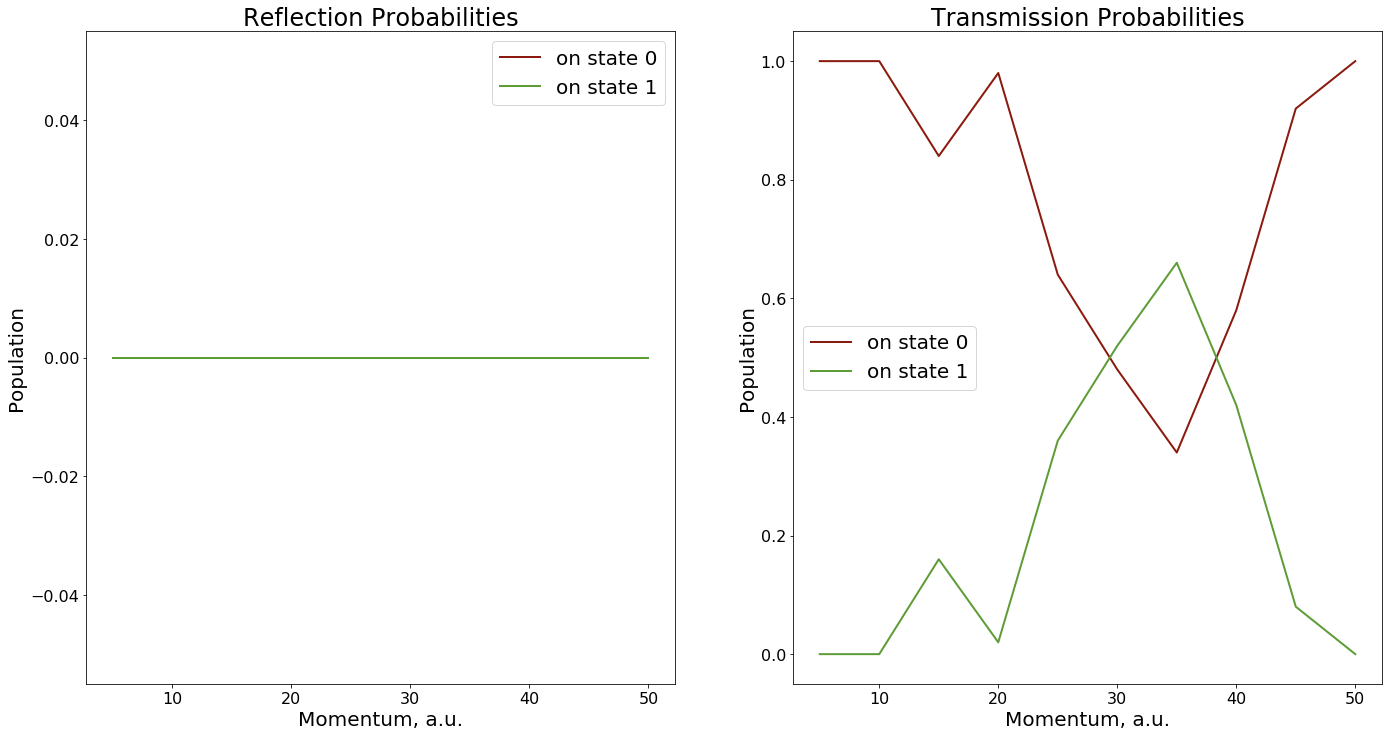

In [15]:
P0 = [5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0]
scan_res = []
for p0 in P0:
    res = run_scan(p0, 2)
    scan_res.append(res)    

# Format: 
#   0      1      2       3        4        5           6          7        8            9       10        11            12        13        14 
#obs_T, obs_q, obs_p, obs_Ekin, obs_Epot, obs_Etot, obs_dEkin, obs_dEpot, obs_dEtot, obs_Cadi, obs_Cdia, obs_dm_adi, obs_dm_dia, obs_pop  obs_states

# scan_res[icond][ivar][istep][i]       for lists
# scan_res[icond][ivar][istep].get(i,j) for matrices

nsteps = len(scan_res[0][0])
ntraj = len(scan_res[0][14][0])

icond = 0 
last_q = scan_res[icond][1][nsteps-1]
last_states = scan_res[icond][14][nsteps-1]

ncond = len(P0)
P_re, P_tr = [], []

for icond in range(ncond):
    
    last_q = scan_res[icond][1][nsteps-1]
    last_states = scan_res[icond][14][nsteps-1]

    pop_refl, pop_transm = tsh_algo1.probabilities_1D_scattering(last_q, last_states, 2, {"act_dof":0, "left_boundary":-5.0, "right_boundary":5.0} )
    P_re.append(pop_refl)
    P_tr.append(pop_transm)


p_re0 = data_conv.unpack1(P_re, 0, 0, 2)
p_re1 = data_conv.unpack1(P_re, 1, 0, 2)
p_tr0 = data_conv.unpack1(P_tr, 0, 0, 2)
p_tr1 = data_conv.unpack1(P_tr, 1, 0, 2)

plt.figure(1, figsize=(24, 12)) # dpi=300, frameon=False)
plt.subplot(1,2,1)
plt.title('Reflection Probabilities')
plt.xlabel('Momentum, a.u.')
plt.ylabel('Population')
plt.plot(P0, p_re0, label='on state 0', linewidth=2, color = colors["11"]) 
plt.plot(P0, p_re1, label='on state 1', linewidth=2, color = colors["21"]) 
plt.legend()

plt.subplot(1,2,2)
plt.title('Transmission Probabilities')
plt.xlabel('Momentum, a.u.')
plt.ylabel('Population')
plt.plot(P0, p_tr0, label='on state 0', linewidth=2, color = colors["11"]) 
plt.plot(P0, p_tr1, label='on state 1', linewidth=2, color = colors["21"]) 
plt.legend()


plt.show()
plt.close()